In [12]:
import itertools
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import confusion_matrix
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [13]:
image_dir = Path('C:/Users/daniel.brooks/Documents/GitHub/Kaggle/Fish_Classification')
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df = image_df[image_df['Label'].apply(lambda x: x[-2:] != 'GT')]

image_df = image_df.sample(frac=1).reset_index(drop = True)

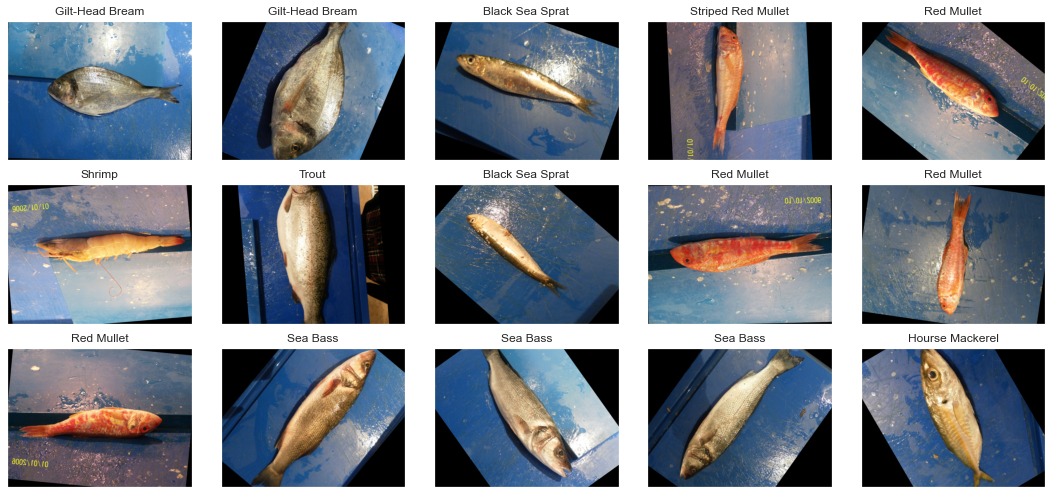

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [15]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1234)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [16]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=1234,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5040 validated image filenames belonging to 9 classes.
Found 1260 validated image filenames belonging to 9 classes.
Found 2700 validated image filenames belonging to 9 classes.


In [17]:
model = Sequential([
    Conv2D(16,(3,3),input_shape=(224, 224, 3)),
    MaxPooling2D(),
    Conv2D(32, (3,3)),    
    Flatten(),
    Dropout(0.3),
    Dense(64, activation = 'relu'),
    Dropout(0.3),
    Dense(9, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
flatten (Flatten)            (None, 380192)            0         
_________________________________________________________________
dropout (Dropout)            (None, 380192)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                24332352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [18]:
tf.keras.backend.clear_session()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=0.0005), metrics = ["accuracy"])
model_history = model.fit(train_images, epochs=15, callbacks =[reduce_lr], validation_data = val_images)

Epoch 1/15
158/158 [==============================] - 77s 483ms/step - loss: 3.4898 - accuracy: 0.1926 - val_loss: 1.5599 - val_accuracy: 0.4921
Epoch 2/15
158/158 [==============================] - 84s 529ms/step - loss: 1.5304 - accuracy: 0.4623 - val_loss: 1.0048 - val_accuracy: 0.6968
Epoch 3/15
158/158 [==============================] - 85s 539ms/step - loss: 1.0807 - accuracy: 0.6030 - val_loss: 0.5011 - val_accuracy: 0.8405
Epoch 4/15
158/158 [==============================] - 83s 526ms/step - loss: 0.6958 - accuracy: 0.7414 - val_loss: 0.3441 - val_accuracy: 0.8960
Epoch 5/15
158/158 [==============================] - 84s 532ms/step - loss: 0.4360 - accuracy: 0.8374 - val_loss: 0.2252 - val_accuracy: 0.9278
Epoch 6/15
158/158 [==============================] - 85s 537ms/step - loss: 0.2839 - accuracy: 0.9003 - val_loss: 0.2300 - val_accuracy: 0.9135
Epoch 7/15
158/158 [==============================] - 84s 529ms/step - loss: 0.2441 - accuracy: 0.9200 - val_loss: 0.1727 - val_ac

In [19]:
scoreSeg = model.evaluate(x=test_images,verbose =1)

85/85 [==============================] - 22s 263ms/step - loss: 0.1283 - accuracy: 0.9619


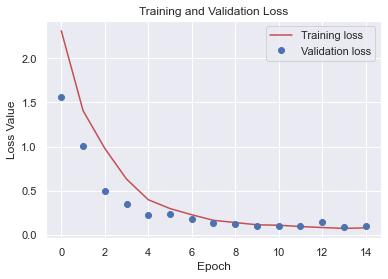

In [20]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
EPOCHS =15
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [21]:
test_predictions = model.predict(test_images)
test_predictions = np.argmax(test_predictions, axis=1)

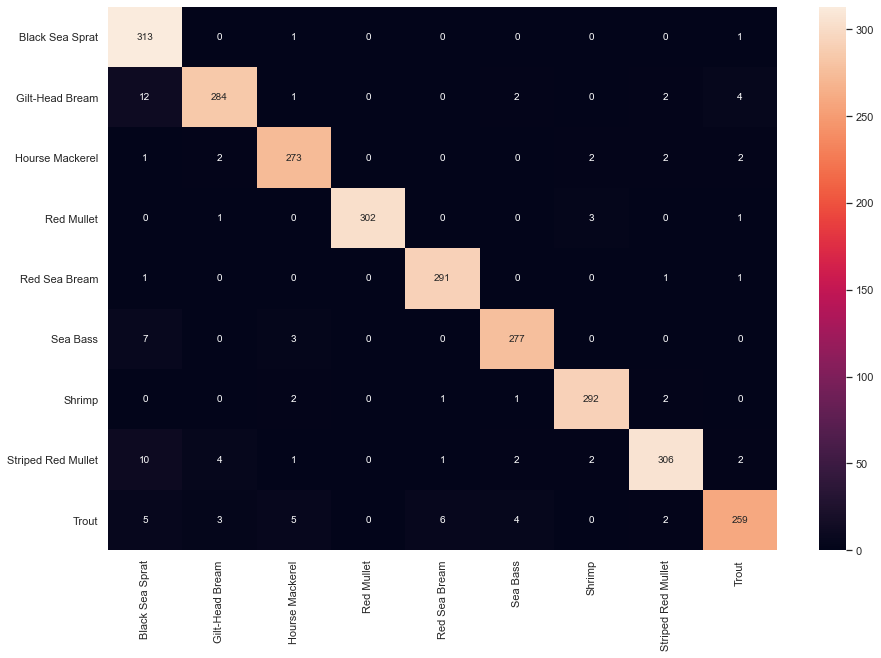

In [22]:
cnf_matrix = confusion_matrix(test_images.labels, test_predictions)
df = pd.DataFrame(cnf_matrix, train_images.class_indices.keys(), train_images.class_indices.keys())

plt.figure(figsize=(15,10))
sns.set(font_scale=1.0) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 10},fmt='d') # font size

plt.show()